# DeepSeedlings: CNN

Using preprocessed images from DeepSeedlings-Part1. Using the pre-trained Keras Xception CNN (with the last layer 'cut' off), we ran the preprocessed images through the model to obtain Xception's vectorized representation for each image.

In this notebook, we build, train and validate additional layers in order to build a pipeline that specializes in  seedling species identification.

In [1]:

import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import cv2
import seaborn as sns
import keras
from keras import backend as K
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
#from sklearn.cross_validation import train_test_split
#from tqdm import tqdm
import pickle
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_train_valid_bf = np.load(os.path.join(os.getcwd(),'x_train_valid_bf.npy'))
y_train_valid = np.load(os.path.join(os.getcwd(),'y_train_valid.npy'))

In [3]:
x_test_bf = np.load(os.path.join(os.getcwd(),'x_test_bf.npy'))

# Prep Train/Validation Data
- shuffle
- train/validation split

In [4]:
# use one-hot encoding for categorial labels
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

# function to shuffle randomly train and validation data
def shuffle_train_valid_data(x_train_valid):
    
    print('shuffle train and validation data')
    
    # shuffle train and validation data of original data
    perm_array = np.arange(len(x_train_valid)) 
    np.random.shuffle(perm_array)
    
    # split train and validation sets based on original data
    x_train = x_train_valid[perm_array[:train_set_size]]
    y_train = dense_to_one_hot(y_train_valid[perm_array[:train_set_size]], num_classes = 12)
    x_valid = x_train_valid[perm_array[-valid_set_size:]]
    y_valid = dense_to_one_hot(y_train_valid[perm_array[-valid_set_size:]], num_classes = 12)
         
    return x_train, y_train, x_valid, y_valid 

In [5]:
# split into train and validation sets
valid_set_size_percentage = 10
valid_set_size = int(len(x_train_valid_bf) * valid_set_size_percentage/100);
train_set_size = len(x_train_valid_bf) - valid_set_size

In [6]:
# shuffle and train/validation split
x_train_bf, y_train, x_valid_bf, y_valid = shuffle_train_valid_data(x_train_valid_bf) 

shuffle train and validation data


In [7]:
print('x_train_bf.shape = ', x_train_bf.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid_bf.shape = ', x_valid_bf.shape)
print('y_valid.shape = ', y_valid.shape)

x_train_bf.shape =  (2160, 2048)
y_train.shape =  (2160, 12)
x_valid_bf.shape =  (240, 2048)
y_valid.shape =  (240, 12)


In [8]:
from keras import backend as K

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))




In [9]:
# lr decay schedule
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 0.0001
    if epoch > 20 :
        lr *= 1e-1
    #elif epoch > 15 :
    #    lr *= 1e-2

    print('Learning rate: ', lr)
    return lr

## Xception CNN  with additional layers

This led to the best results for my project.

In [10]:
x_size = x_train_bf.shape[1] # features 
y_size = 12

In [11]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
#model.add(x_conv)
 
# Add new layers
#model.add(layers.Flatten())
model.add(layers.Dense(1024, input_dim = x_size, activation='relu'))
model.add(layers.Dropout(0.33))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.33))
model.add(layers.Dense(12, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                3084      
Total params: 2,363,660
Trainable params: 2,363,660
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Callbacks
tensorboard = TensorBoard(log_dir = './logs')

checkpointer = ModelCheckpoint(filepath='/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)


# Compile the model


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr_schedule(0)),
              metrics=['acc', precision, recall, f1])

lr = LearningRateScheduler(lr_schedule)
# Train the model

 
history = model.fit(x=x_train_bf, y=y_train,  epochs=40, verbose=1, validation_data=(x_valid_bf, y_valid), callbacks = [tensorboard, checkpointer, lr])
                    #callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, 
                    #class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)
# Save the model
#model.save('small_last4.h5')

Learning rate:  0.0001
Train on 2160 samples, validate on 240 samples
Epoch 1/40
Learning rate:  0.0001
2160/2160 [==============================] - 1s 323us/step - loss: 1.7394 - acc: 0.4819 - precision: 0.3860 - recall: 0.0588 - f1: nan - val_loss: 1.0950 - val_acc: 0.6833 - val_precision: 0.8474 - val_recall: 0.3042 - val_f1: 0.4451

Epoch 00001: val_loss improved from inf to 1.09497, saving model to /tmp/weights.01-1.09.hdf5
Epoch 2/40
Learning rate:  0.0001
2160/2160 [==============================] - 0s 206us/step - loss: 0.9969 - acc: 0.6894 - precision: 0.8327 - recall: 0.4301 - f1: 0.5593 - val_loss: 0.7224 - val_acc: 0.7625 - val_precision: 0.8420 - val_recall: 0.5958 - val_f1: 0.6969

Epoch 00002: val_loss improved from 1.09497 to 0.72241, saving model to /tmp/weights.02-0.72.hdf5
Epoch 3/40
Learning rate:  0.0001
2160/2160 [==============================] - 0s 204us/step - loss: 0.7180 - acc: 0.7690 - precision: 0.8633 - recall: 0.6319 - f1: 0.7268 - val_loss: 0.6025 - val_

In [14]:
model.save('xception_trained_seedlings.h5')

# Results

In [15]:
y_valid_predict_proba = model.predict(x_valid_bf, verbose =1)

240/240 [==============================] - 0s 131us/step


In [16]:
y_valid_predict_species = []
for pred in y_valid_predict_proba:
    y_valid_predict_species.append(np.argmax(pred))

In [17]:
cnf_matrix = confusion_matrix(one_hot_to_dense(y_valid), y_valid_predict_species)

In [18]:
cnf_matrix

array([[12,  0,  0,  0,  1,  0,  8,  0,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  0, 13,  0,  0,  0,  0,  1,  1,  0,  0],
       [ 1,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0],
       [ 4,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  0,  0,  0, 17,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0, 20,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0, 14]])

In [19]:
print(classification_report(one_hot_to_dense(y_valid), y_valid_predict_species))

             precision    recall  f1-score   support

          0       0.71      0.57      0.63        21
          1       0.87      0.95      0.91        21
          2       1.00      0.88      0.93        16
          3       0.76      0.87      0.81        15
          4       0.95      0.90      0.92        20
          5       0.89      0.96      0.93        26
          6       0.62      0.79      0.70        19
          7       0.95      0.91      0.93        22
          8       0.94      0.77      0.85        22
          9       0.91      1.00      0.95        20
         10       0.91      0.95      0.93        21
         11       0.93      0.82      0.87        17

avg / total       0.87      0.87      0.87       240



In [20]:
accuracy_score(one_hot_to_dense(y_valid), y_valid_predict_species)

0.8666666666666667

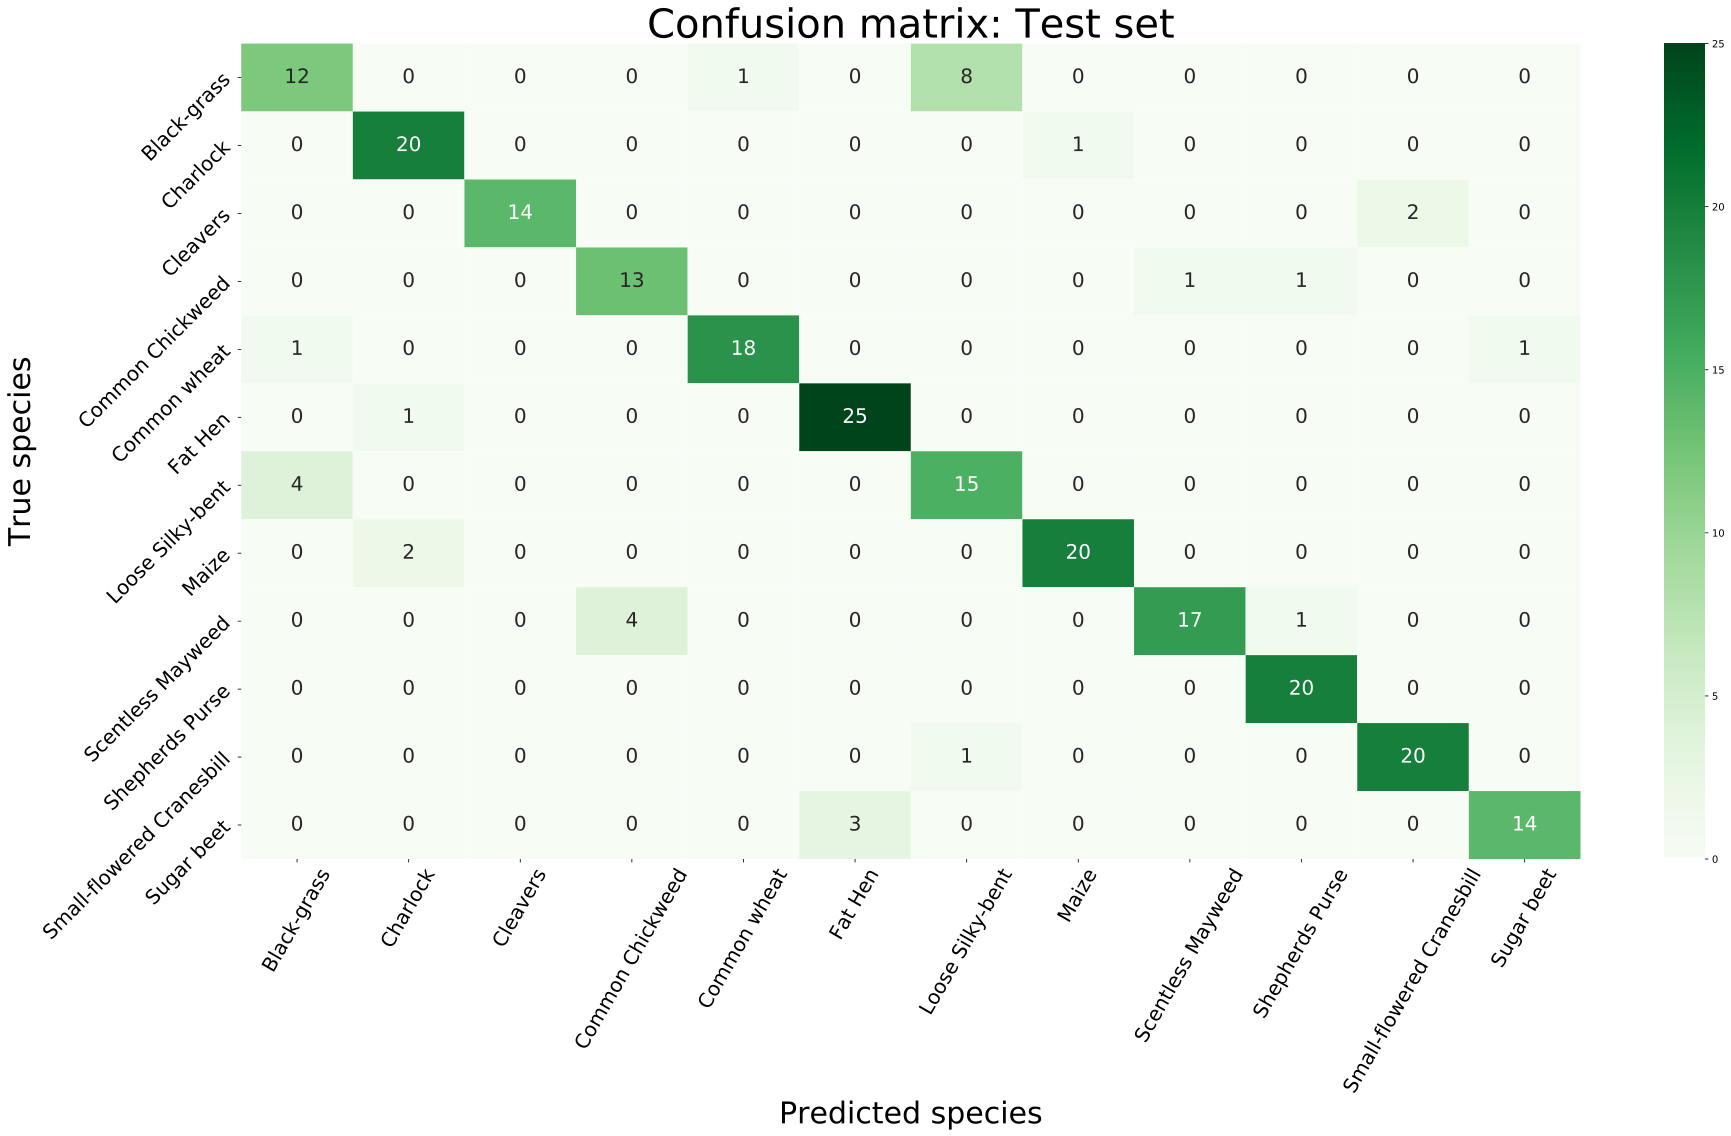

In [33]:
abbreviation = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


fig, ax = plt.subplots(1, figsize = (30,15))

ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True, annot_kws={"size": 20})
ax.set_xticklabels(abbreviation, rotation = 60, fontsize = 20)
ax.set_yticklabels(abbreviation, rotation = 45, fontsize = 20)
plt.title('Confusion matrix: Test set', fontsize = 40)
plt.ylabel('True species', fontsize = 30)
plt.xlabel('Predicted species', fontsize = 30)
plt.show()
plt.savefig('conf_matrix')

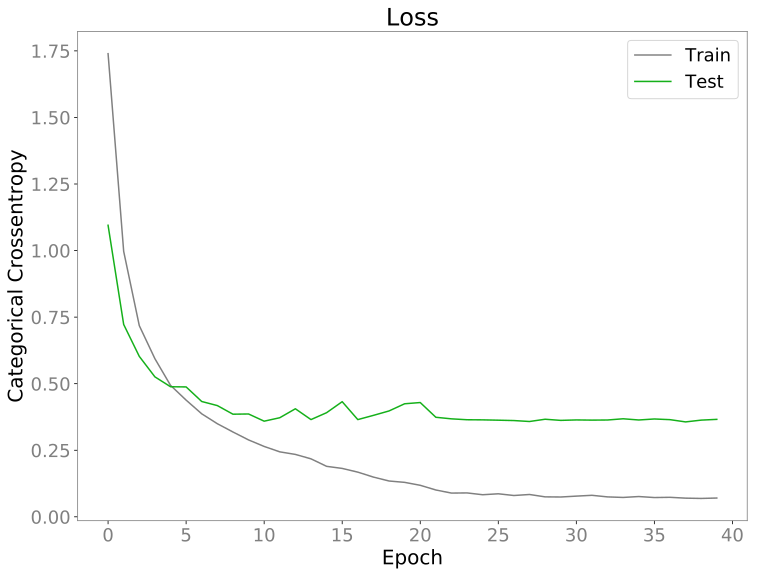

In [34]:
plt.rc('axes',edgecolor='grey')

plt.figure(figsize = (12,9))
plt.title("Loss", fontsize = 24)
plt.plot(history.history["loss"], color="grey", label="Train")
plt.plot(history.history["val_loss"], color="xkcd:green", label="Test")
plt.legend(loc="best", fontsize = 18)
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Categorical Crossentropy', fontsize = 20)
plt.xticks(fontsize=18, color = 'grey')
plt.yticks(fontsize=18, color = 'grey')
plt.savefig('Loss_v_epochs')

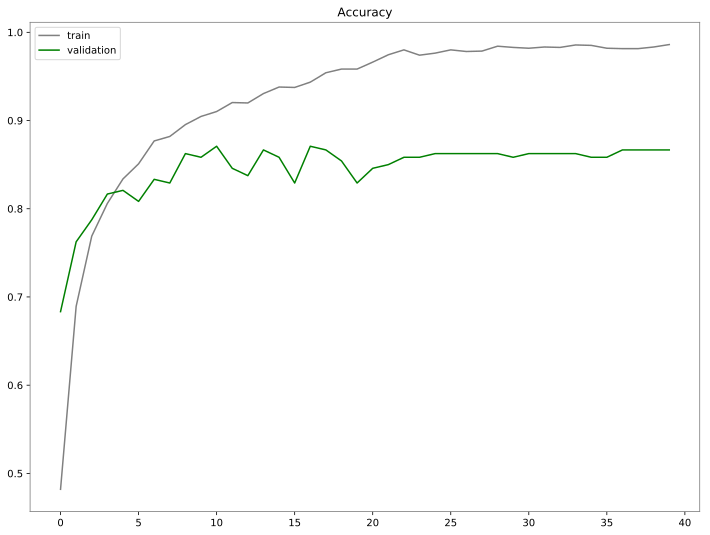

In [23]:
plt.figure(figsize = (12,9))
plt.title("Accuracy")
plt.plot(history.history["acc"], color="grey", label="train")
plt.plot(history.history["val_acc"], color="g", label="validation")
plt.legend(loc="best")

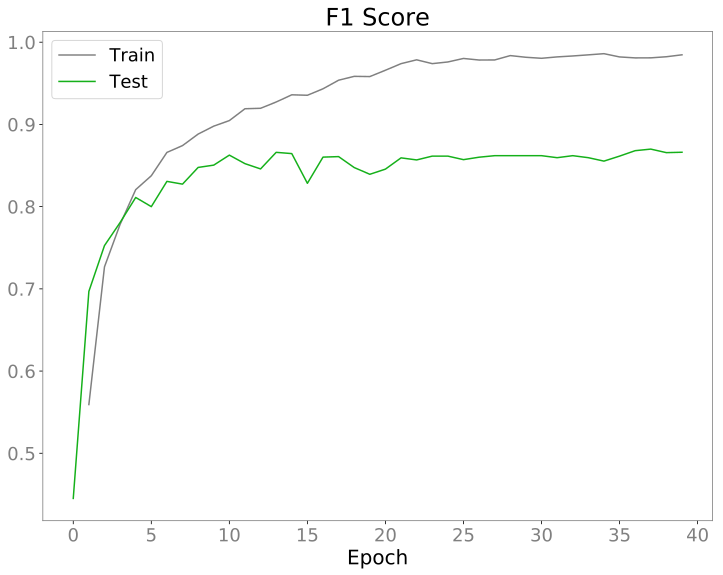

In [35]:
plt.figure(figsize = (12,9))
plt.title("F1 Score", fontsize = 24)
plt.plot(history.history["f1"], color="grey", label="Train")
plt.plot(history.history["val_f1"], color="xkcd:green", label="Test")
plt.legend(loc="best", fontsize = 18)
plt.xticks(fontsize=18, color = 'grey')
plt.yticks(fontsize=18, color = 'grey')
plt.xlabel('Epoch', fontsize = 20)
plt.savefig('F1_v_epochs')

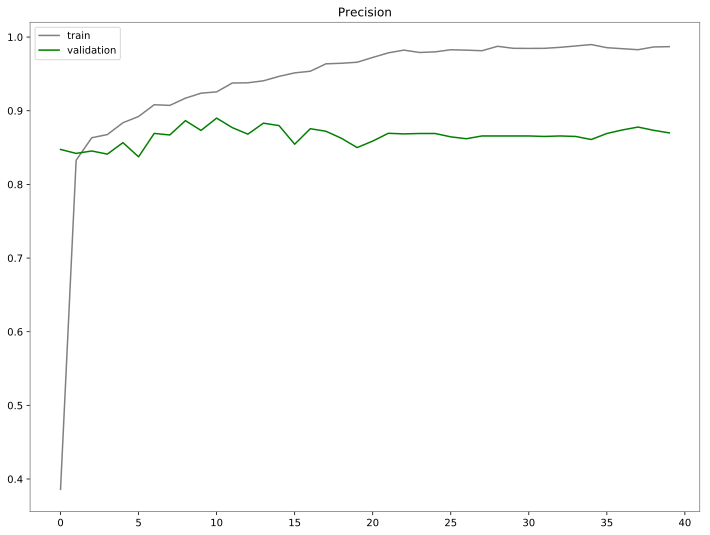

In [25]:
plt.figure(figsize = (12,9))
plt.title("Precision")
plt.plot(history.history["precision"], color="grey", label="train")
plt.plot(history.history["val_precision"], color="g", label="validation")
plt.legend(loc="best")

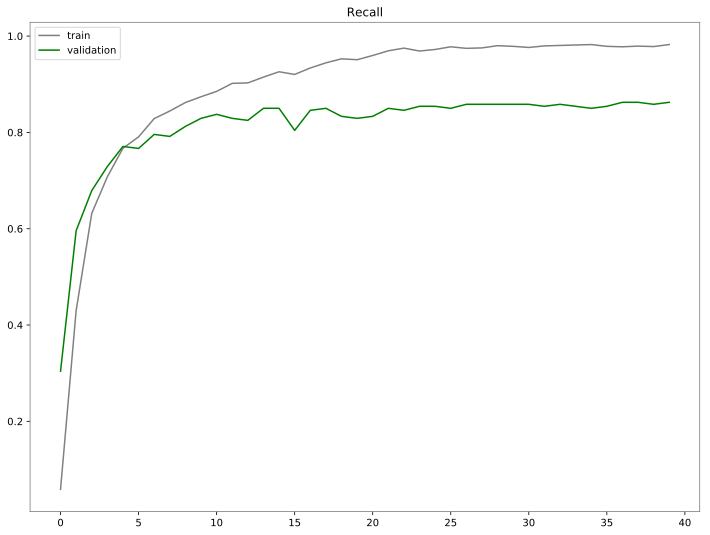

In [26]:
plt.figure(figsize = (12,9))
plt.title("Recall")
plt.plot(history.history["recall"], color="grey", label="train")
plt.plot(history.history["val_recall"], color="g", label="validation")
plt.legend(loc="best")

# Try retraining part of XCeption

This did not lead to the best results, but it was an interesting experiment.

In [27]:
x_train_valid = np.load(os.path.join(os.getcwd(),'x_train_valid_imgs.npy'))
y_train_valid = np.load(os.path.join(os.getcwd(),'y_train_valid.npy'))
x_test = np.load(os.path.join(os.getcwd(),'x_test_imgs.npy'))

In [28]:
# split into train and validation sets
valid_set_size_percentage = 10
valid_set_size = int(len(x_train_valid) * valid_set_size_percentage/100);
train_set_size = len(x_train_valid) - valid_set_size

In [29]:
# shuffle and train/validation split
x_train, y_train, x_valid, y_valid = shuffle_train_valid_data(x_train_valid) 

shuffle train and validation data


In [30]:
x_conv = xception.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling = 'avg')

KeyboardInterrupt: 

In [ ]:
## Freeze the layers except the last 4 layers
for layer in x_conv.layers[:-4]:
    layer.trainable = False
 
## Check the trainable status of the individual layers
#for layer in x_conv.layers:
#    print(layer, layer.trainable)

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(x_conv)
 
# Add new layers
#model.add(layers.Flatten())
model.add(layers.Dense(1024,  activation='relu'))
model.add(layers.Dropout(0.33))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.33))
model.add(layers.Dense(12, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

In [ ]:
# Callbacks
tensorboard = TensorBoard(log_dir = './logs')

checkpointer = ModelCheckpoint(filepath='/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)


# Compile the model


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr_schedule(0)),
              metrics=['acc', precision, recall, f1])

lr = LearningRateScheduler(lr_schedule)
# Train the model

 
history = model.fit(x=x_train, y=y_train,  epochs=40, verbose=1, validation_data=(x_valid, y_valid), callbacks = [tensorboard, checkpointer, lr])
                    #callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, 
                    #class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)
# Save the model
#model.save('small_last4.h5')